# Facebook: Paid vs Unpaid Posts

### Introduction:
Facebook is one of the biggest social media platforms known to society, and it is a great place for businesses to reach consumers globally. Hence, we will be using two different metrics for Facebook posts to answer: can we use the amount of lifetime post total reach and lifetime people who have liked the page and engaged with the post to predict whether the post was paid or unpaid? The dataset we have is from 2014 Facebook posts of a renowned cosmetic brand, and it shows the type of post (paid vs unpaid) as well as information on it. The data will be split into a 75% training and 25% testing set, and a classifier will be built with K nearest neighbour. 


### Preliminary exploratory data analysis:
The dataset is downloadable in csv format, which we then uploaded to Jupyter in a folder called "data". Furthermore, we do not have to tidy the dataset as it is already in tidy format.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

Page.total.likes,Type,Category,Post.Month,Post.Weekday,Post.Hour,Paid,Lifetime.Post.Total.Reach,Lifetime.Post.Total.Impressions,Lifetime.Engaged.Users,Lifetime.Post.Consumers,Lifetime.Post.Consumptions,Lifetime.Post.Impressions.by.people.who.have.liked.your.Page,Lifetime.Post.reach.by.people.who.like.your.Page,Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post,comment,like,share,Total.Interactions
<int>,<chr>,<int>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


`summarise()` ungrouping output (override with `.groups` argument)



Paid,n,LifetimePostTotalReachMean,LifetimePeopleMean
<fct>,<int>,<dbl>,<dbl>
0,270,12666.84,581.6741
1,105,19660.85,633.1619
NA,1,4188.00,316.0000


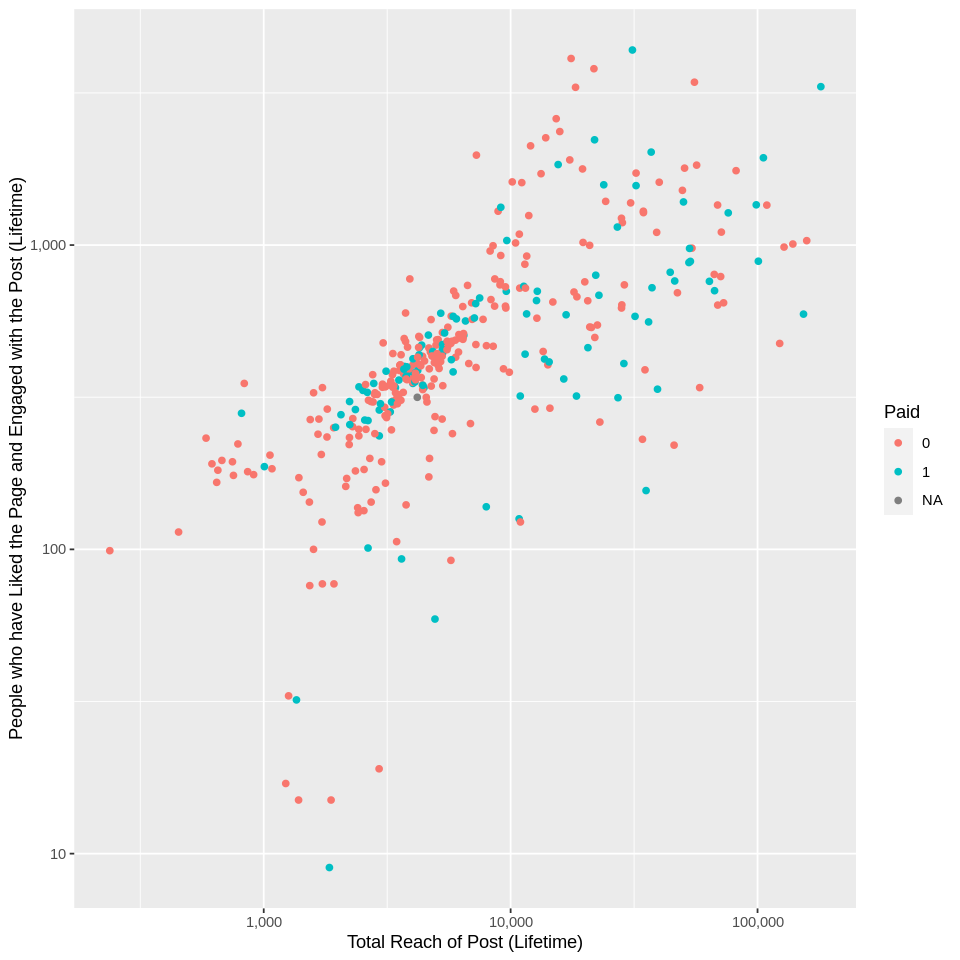

In [2]:
set.seed(3060)
options(repr.plot.width = 8, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)
facebook <- mutate(read.delim('data/dataset_Facebook.csv', sep=';'), Paid=as_factor(Paid))
facebook

facebook_split <- initial_split(facebook, prop = 0.75, strata = Paid) 
facebook_train <- training(facebook_split)   
facebook_test <- testing(facebook_split)

facebook_group <- facebook_train %>% group_by(Paid)%>% 
summarize(n=n(),LifetimePostTotalReachMean = mean(Lifetime.Post.Total.Reach, na.rm =TRUE), LifetimePeopleMean = mean(Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post, na.RM=TRUE))
facebook_group

facebook_plot <- facebook_train %>% ggplot(aes(x=Lifetime.Post.Total.Reach, 
            y=Lifetime.People.who.have.liked.your.Page.and.engaged.with.your.post)) + 
            geom_point(aes(color=Paid)) + labs(x='Total Reach of Post (Lifetime)', y='People who have Liked the Page and Engaged with the Post (Lifetime)', color='Paid') +
            scale_x_log10(labels = scales::comma) +
            scale_y_log10(labels = scales::comma)
facebook_plot

### Methods:
We will use the recipe/model to conduct predictions on the test set to classify whether the post is paid (1) or unpaid (0). We chose 75% for the training set as the data frame has 500 rows, and 375 rows would be a good starting point to build the model. We are planning to start with 5 folds for cross validation, and if the accuracy is low, then we can increase the number of folds to 10. We are using cross validation to choose the best K or number of neighbours, retraining and building our final model on the optimal K value. The columns we chose are the total reach and total people who liked the page and engaged with the post for both paid and unpaid posts. We can compare to determine if a relatively high total reach and more engagements on the post and page means that the post is paid or unpaid.

A higher total reach means more users who have seen the post in their news feed whereas the other variable means users are also interested and invested in the contents of the page. Just because people see the post, does not mean they engage with it, which is a reason why we chose the two columns to analyze.

As seen by the graph above, it is very hard for us to visualize the dots as they are very close to one another, so we will most likely be relying on prediction tables through training and testing datasets to see the accuracy of our predictions.


### Expected outcomes and significance:
1. We expect to find that a relatively high total post reach and liked page/engaged post would mean that the post was paid.
2. This model will hopefully be useful in designing marketing strategies to create more effective advertisement. Whether the business chooses to pay for a post, it would most likely have the amount of reach and engagement they want. Hence, the model will help in budgeting for advertisement, especially for smaller businesses or start-ups that have less funds.
3. Does a higher reach necessarily mean more people would be interested in the post regardless of quality of the post? Should a company pay for a post only if it is guranteed a certain cutoff of numbers of reach and people who have engaged with the post and liked the page? Which is more significant to a business: post reach or engagement with the post, or are there more variables to consider?